# A Modern Bayesian workflow in PyMC3

PyMC3 and its implementation of dynamic Hamiltonian Monte Carlo is an extremely powerful tool for specifying and then fitting complex Bayesian models. In order to ensure a robust analysis, however, that power must be complemented with responsibility.

In particular, while dynamic implementations of Hamiltonian Monte Carlo, i.e. implementations where the integration time is dynamic, do perform well over a large class of models their success is not guaranteed. When they do fail, however, their failures manifest in diagnostics that are readily checked.

By acknowledging and respecting these diagnostics you can ensure that PyMC3 is accurately fitting the Bayesian posterior and hence accurately characterizing your model. And only with an accurate characterization of your model can you properly utilize its insights.

# A little bit of MCMC
Hamiltonian Monte Carlo is an implementation of Markov chain Monte Carlo, an algorithm which approximates expectations with respect to a given target distribution, π,
$E_π[f]=∫dqπ(q)f(q),$
using the states of a Markov chain, ${q_0,…,q_N}$,
$$E_π[f]≈\hat{f}_N=\dfrac{1}{N+1}∑_{n=0}^{N}f(q_n).$$
Typically the target distribution is taken to be the posterior distribution of our specified model.

These estimators are guaranteed to be accurate only asymptotically, as the Markov chain grows to be infinitely long,
$$\lim_{N→∞}\hat{f}_{N}=E_{π}[f].$$

To be useful in applied analyses, we need these Markov chain Monte Carlo estimators to converge to the true expectation values sufficiently quickly that they are reasonably accurate before we exhaust our finite computational resources. This fast convergence requires strong ergodicity conditions to hold, typically a condition called geometric ergodicity between the Markov transition and target distribution. In particular, geometric ergodicity is a sufficient condition for Markov chain Monte Carlo estimators to follow a central limit theorem, which ensures not only that they are unbiased after only a finite number of iterations but also that we can empirically quantify their precision,

$$\hat{f}_{N}−E_{π}[f]\;\tilde\;N(0,\sqrt{Var[f]/N_{eff}}).$$

Unfortunately proving geometric ergodicity theoretically is infeasible for any nontrivial problem. Instead we must rely on empirical diagnostics that identify obstructions to geometric ergodicity, and hence well-behaved Markov chain Monte Carlo estimators. For a general Markov transition and target distribution, the best known diagnostic is the split R^ statistic over an ensemble of Markov chains initialized from diffuse points in parameter space.
To do any better we need to exploit the particular structure of a given transition or target distribution.

Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore. Another is the energy Bayesian fraction of missing information, or E-BFMI, which quantifies the efficacy of the momentum resampling in between Hamiltonian trajectories.

For more details on Markov chain Monte Carlo and Hamiltonian Monte Carlo see Betancourt (2017).

In this case study I will demonstrate the recommended PyMC3 workflow where we not only fit a model but also scrutinize these diagnostics and ensure an accurate fit.

## Setting up PyMC3
We begin by setting up the PyMC3 environment. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm
from __future__ import division

SEED = 20090425
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/jupyter_virtual_envs/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Specifying and Fitting a model in PyMC3
To demonstrate the recommended PyMC3 workflow let’s consider a hierarchical model of the eight schools dataset infamous in the statistical literature (D. B. Rubin 1981).

### Model statement  and notation background.  (high level introduction)
A study was performed for the Educational Testing Service to analyze the effects of special coaching programs on test scores. Separate randomized experiments were performed to estimate the effects of coaching programs for the SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.

Would it be possible to have one school's observed effect be 28 just by chance, if the coaching effects in all eight schools were really the same? To get a feeling for this natural variation that we would expect across eight studies if this assumption were true, suppose the estimated treatment effects are eight independent draws from a normal distribution with mean 8 points and standard deviation 13 points (the square root of the mean of the eight variances $\sigma_{j}^{2}$ ). Then, based on the expected values of normal order statistics, we would expect the largest observed value of $y_{j}$ to be about 26 points and the others, in diminishing order, to be about 19, 14,10, 6, 2, -3, and -9 points. These expected effect sizes are consistent with the set of observed effect sizes in the table below. Thus, it would appear imprudent to believe that school A really has an effect as large as 28 points. 




| School        | Estimated treatment effect, yj       |Standard error of effect estimate, σj  |
| ------------- |:-------------:| -----:|
| A      | 28 | 15 |
| B      | 8      |   10 |
| C | -3    |    16 |
| D      | 7 | 15 |
| E     | -1      |   10 |
| F | 1      |    16 |
| G      | 18 | 15 |
| H      | 12      |   10 |

Now, suppose I want to estimate the “true effect size” in School A.  One argument is that the best estimate is 28 points. I have an unbiased estimate and a standard error, what else can I hope for?

On the other hand, the standard error is larger than the estimated effect in most of the schools. A  hypothesis test fails to reject the hypothesis that the true effect size is the same — 8 points — in all of the schools. So another argument is that my best estimate of the effect in School A is 8 points. After all, the “same course” was taught in each of the schools, so each of these eight schools gives me a single estimate of the same quantity, which is the course effectiveness.

Rubin thought (and I think most people would agree) that neither of those arguments represents our state of knowledge.  The first argument would treat School A completely in isolation, ignoring the fact that we have considerable evidence that courses similar to the one taught in School A evidently have typical effect size less than 20 points. The second argument would assume that the true effect in all schools is exactly equal, in spite of the courses being taught by different teachers to different students. Rubin suggested a sort of middle path: (1) assume that each school’s “true effect” is drawn from a normal distribution with unknown mean and standard deviation, and (2) assume  the observed effect in each school is sampled from a normal distribution with a mean equal to the true effect, and standard deviation given in the table above.  (As a physicist I recognized this as an “inverse problem”: we are given the results in the table above, and we have to work backwards to deduce the underlying parameters that produced them. )

An interesting feature of Rubin’s model is that it contains both of the conventional approaches discussed above as special cases: if we force the standard deviation of true effects to be zero then all of the schools end up with the same estimated true effect (with a central estimate of 8 points), whereas if we force the standard deviation of true effects to infinity then each school’s estimated true effect is equal to its observed effect. One can play around with a few different prior distributions for the standard deviation of true effects and find that it doesn’t really matter, any reasonable choice that doesn’t force the standard deviation to be very small or very large turns out to give about the same statistical distribution. 

### A discussion of the coaching effects (More mathematical details)

The estimated coaching effects are $\bar{y}_{j}$, and their sampling variances, $\sigma_{j}^{2}$... The estimates $\bar{y}_{j}$ are obtained by independent experiments and have approximately normal sampling distributions with sampling variances that are known, for all practical purposes, because the sample sizes in all of the eight experiments were relatively large, over thirty students in each school. 

Notice the bar on the y’s (the estimated) and the mention of standard errors (rather than standard deviations) in the third column in the table above. Why is this?

The answer is that these are means taken over many (> 30) students in each of the schools. The general structure of this model can be written thus:
     
* Consider J independent experiemnts, with experiment j estimating the parameter $\sigma_j$ from $n_{j}$ independent normally distributed data points, $y_{ij}$, each with known error variance $\sigma^{2}$, that is, 

* $$y_{ij}| \sigma_j \;\tilde\; N(\theta_j , \sigma^2), i=1, \cdots, n_{j}; j =1, \cdots, J. $$

We label the sample mean of each group j as 

* $$\bar{y}_{j} = 1/n_{j} \Sigma_{i=1}^{n_{j}} y_{ij} $$

with sampling variance: 
* $$\sigma_{j}^{2} = \sigma^{2} / n_{j}$$

We can then write the likelihood for each $\theta_j$ using the sufficient statistics, $\bar{y}_j$:
* $$\bar{y}_j | \theta_{j} \;\tilde\; N(\theta_j, \sigma_j^2)$$

This is 
- A notation that will prove useful later because of the flexibility in allowing a seperate variance $\sigma_{j}^{2}$ for the mean of each group j, $\cdots$ all expressions will be implicitly conditional on the known values $\sigma_j^2 \cdots$ Although rarely strictly true, the assumption of known variances at the sampling level of the model is often an adequate approximation. 

The treatment of the model provided … is also appropriate for situations in which the variances differ for reasons other than the number of data points in the experiment. In fact, the likelihood can appear in much more general contexts than that stated here. For example, if the group sizes $n_j$ are large enough, then the means $\bar{y}_{j}$ are approximately normally distributed, given $\theta_{j}$, even when the data $y_{ij}$ are not.
### The statistical model without background.  (Barebones mathematical explnation) 
Let us consider the statistical model as it is normally stated. 

We compute the posterior distribution of $θ_1, …, θ_8,$ based on the normal model presented below (More discussion of the reasonableness of applying this model in this problem appears in Sections 6.5 and 17.4. of Bayesian Data Analysis) We draw from the posterior distribution for the Bayesian model by simulating the random variables τ, μ, and θ, in that order, from their posterior distribution, as discussed at the end of the previous section. The sampling standard deviations, $σ_j$, are assumed known and equal to the values in Table 5.2, and we assume independent uniform prior densities on μ and τ.

$$μ∼N(0,5)$$


$$τ∼\mathrm{Half Cauchy}(0,5)$$


$$θ_{n}∼N(μ,τ)$$

$$y_n∼N(θ_n,σ_n),$$


where $n\;∈\;{1,…,8}$ and the ${y_n,σ_n}$ are given as data.

Inferring the hierachical hyper parameters, $\mu$ and $\sigma$, together with the group-level parameters $\theta_1, \cdots, \theta_8$, allows the model to pool data across the groups and reduce their posterior variance. Unfortunately this pooling also squeezes the posterior distribution into a particularly challenging geometry that obstructs geometric ergodicity and hence biases MCMC estimation. 

In this case study we’ll first examine the direct centered parameterization of the Eight Schools model and see how divergences identify this bias before there are any other indications of problems. We’ll then use these divergences to study the source of the bias and motivate the necessary fix, a reimplementation of the model with a non-centered parameterization.

For more information on the eight schools dataset see Gelman et al. (2014).
http://andrewgelman.com/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/

https://www.safaribooksonline.com/library/view/bayesian-data-analysis/9781439898222/OEBPS/c5.htm -- Bayesian Data Analysis book - Rubin, Gelman, et al





Cauchy
* https://en.wikipedia.org/wiki/Cauchy_distribution
* https://stats.stackexchange.com/questions/237847/what-are-the-properties-of-a-half-cauchy-distribution

In [3]:
# Data of the Eight Schools Model
J = 8 # Num schools
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12], dtype=float) # Estimated treament effects
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18], dtype=float) # s.e. of effect estimates
# tau = 25.

## Fitting the model 
Now let us fit the model, and we can turn to PyMC3 to quantify the resulting posterior distribution with Hamiltonian Monte Carlo. 

In [4]:
# mu, tau etc. are PyMC3 stochastic variables, which you can sample from using a method
# Create random variables using pm.Model()
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5) # Prior
    tau = pm.HalfCauchy('tau', beta=5) # Prior
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J) # Prior
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y) # Likelihood

In [26]:
# pm.sample() returns samples form obs - the last thing in the with statement
with Centered_eight:
    short_trace = pm.sample(400, njobs=2, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 98%|█████████▊| 882/900 [00:04<00:00, 176.51it/s]/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 400 samples.
  % (self._chain_id, n))
/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 11 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 900/900 [00:04<00:00, 198.68it/s]
/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 1 contains only 400 samples.
  % (self._chain_id, n))
/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 9 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  %

We recommend explicitly specifying the seed of PyMC3 random number generator, as we have done here, so that we can reproduce these exactly results in the future, at least when using the same machine, operating system, and interface.
This is especially helpful for the more subtle pathologies that may not always be found, which results in seemingly stochastic behavior.

In the the original post a single chain of 1200 sample is applied. However, since split R^ is not implemented in PyMC3 we fit 2 chains with 400 sample each instead.



## Validating a fit in PyMC3. 
Now let's look at the Gelman-Rubins statistic - this is a bit like $R^{2}$ - it should be close to 1. 

In [27]:
print(pm.diagnostics.gelman_rubin(short_trace))


{'mu': 0.9990869597783998, 'theta': array([1.00175822, 0.99882524, 0.99993035, 0.99916857, 1.0011139 ,
       0.99875689, 0.99881999, 0.99899413]), 'tau': 1.0012115588241117}


The Gelman-Rubin diagnostic R^ doesn’t indicate any problems (values are all close to 1) and the effective sample size per iteration is reasonable. Empirically we have found that R^ greater than 1.1 is usually indicative of problems in the fit. 

In [28]:
print(pm.diagnostics.effective_n(short_trace))


{'mu': 96.0, 'theta': array([146., 240., 268., 281., 264., 276., 231., 337.]), 'tau': 98.0}


Moreover, the trace plots all look fine. Let’s consider, for example, the hierarchical standard deviation τ, or more specifically, its logarithm, log(τ). Because τ is constrained to be positive, its logarithm will allow us to better resolve behavior for small values. Indeed the chains seems to be exploring both small and large values reasonably well,

In [29]:
short_trace.varnames

['mu', 'tau_log__', 'theta', 'tau']

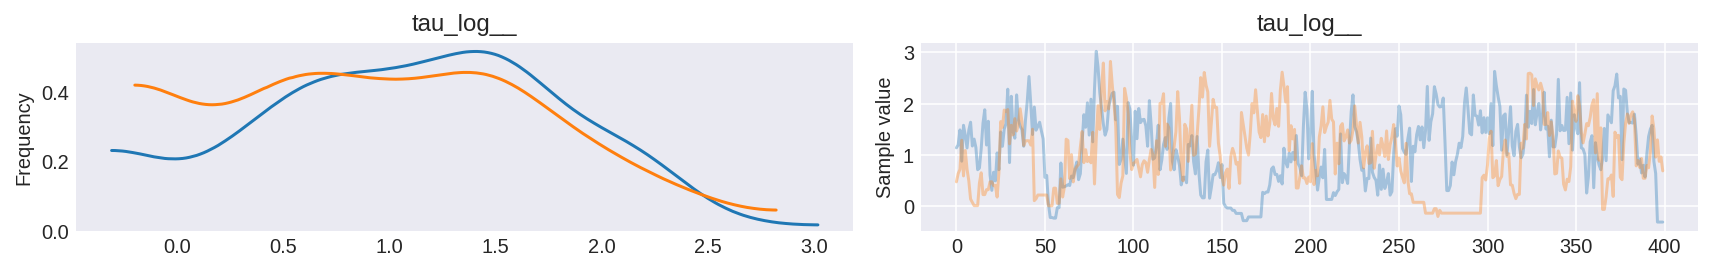

In [30]:
# plot the trace of log(tau)
pm.traceplot(short_trace, varnames=['tau_log__']);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The two colours in this case are the two chains. 

## Checking the E-BFMI
Hamiltonian Monte Carlo proceeds in two phases – the algorithm first simulates a Hamiltonian trajectory that rapidly explores a slice of the target parameter space before resampling the auxiliary momenta to allow the next trajectory to explore another slice of the target parameter space. Unfortunately, the jumps between these slices induced by the momenta resamplings can be short, which often leads to slow exploration.

We can identify this problem by consulting the energy Bayesian Fraction of Missing Information,

In [31]:
bfmi = pm.bfmi(short_trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(short_trace).values())

In [32]:
CONVERGENCE_TITLE = lambda: "BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)



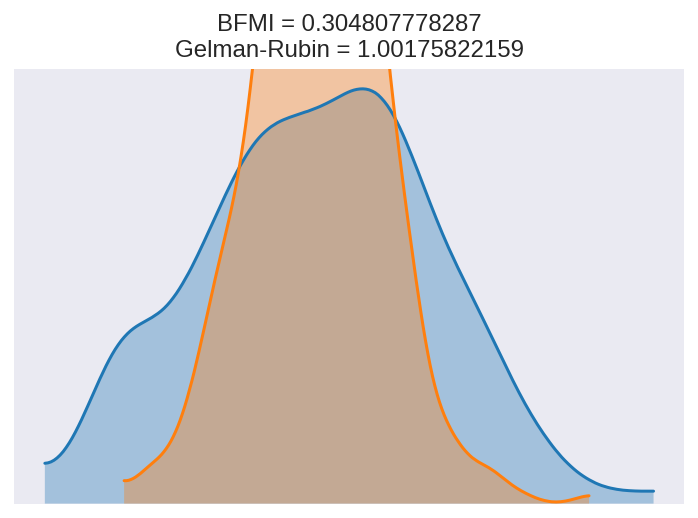

In [33]:
(pm.energyplot(short_trace, legend=False, figsize=(6, 4))
   .set_title(CONVERGENCE_TITLE()));

Let's discuss these further:

- Energy plots: if the two distributions in the energy plot differ significantly (especially in the tails), the sampling was not very efficient.
- Bayesian fraction of missing information (BFMI): BFMI quantifies this difference with a number between zero and one. A BFMI close to (or exceeding) one is preferable, and a BFMI lower than 0.2 (or 0.3) is indicative of efficiency issues.
- Gelman-Rubin statistics: Gelman-Rubin statistics near one are preferable, and values less than 1.1 are generally taken to indicate convergence.

So we have according to the BFMI a poorly formed model. These problems are remedied by tweaking the specification of the model. 
Unfortunately the exact tweaks required depend upon the specification of the model and, consequently, there are no generic solutions. 

## Check divergences
Finally, we can check divergences which indicate pathological neighborhoods of the posterior that the simulated Hamiltonian trajectories are not able to explore sufficiently well. For this fit we have a significant number of divergences

In [34]:

# display the total number and percentage of divergent
divergent = short_trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(short_trace)
print('Percentage of Divergent %.10f' % divperc)

Number of Divergent 20
Percentage of Divergent 0.0500000000


We plot the cumulative mean of $log(\tau)$ as time goes on. This definitely shows some problems. Its biased above the value you would expect from many many samples.

Text(0.5,1,u'MCMC estimation of log(tau)')

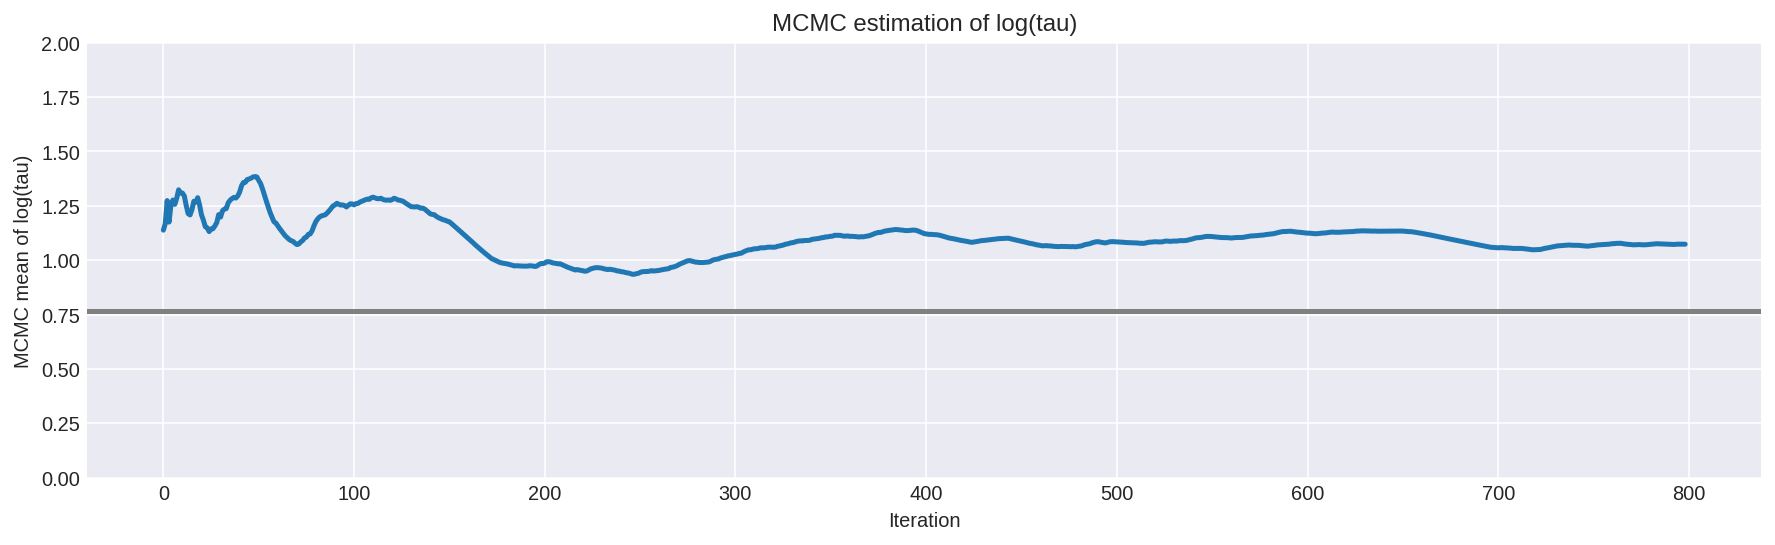

In [35]:
# plot the estimate for the mean of log(τ) cumulating mean
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

What does divergent actually mean? These are situations where our symplectic integrator has completely gone haywire, as illustrated in the this diagram below from Betancourt's review.
![img](https://am207.github.io/2017/wiki/images/sympldiv.png)

When a MCMC sampler (this problem is worse in non HMC models) encounters a region of high curvature it gets stuck, and goes off elsewhere, after a while. In the HMC scenario, the symplectic integrator diverges. What happens is that in encounters a region of high curvature which our timestep size $ϵ$ is not able to resolve. Things become numerically unstable and the integrator veers off towards infinite energies, clearly not conserving energy any more.
![img](https://am207.github.io/2017/wiki/images/sympldiv2.png)

Where is this curvature coming from

Where is this curvature coming from? Things become a bit easier to understand if we plot the joint distribution of one of the thetas against a hyper-parameter. And we see that there is a triangular funnel structure with the hyperparameter spanning orders of magnitude in value. Using pymc we can plot where the divergences occur, and while they can occur anywhere they seem to be clustered in the neck of the distribution.
Additionally, because the divergent transitions, here shown here in green, tend to be located near the pathologies we can use them to identify the location of the problematic neighborhoods in parameter space.

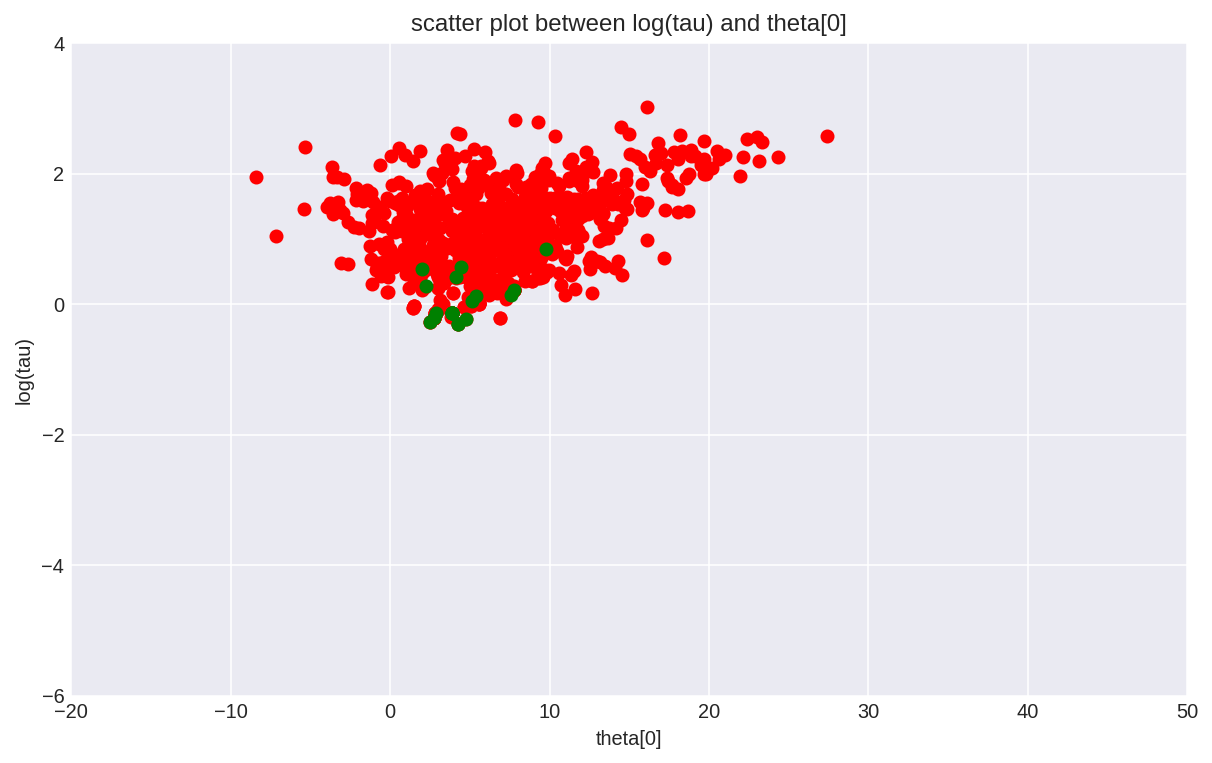

In [36]:
# scatter plot between log(tau) and theta[0]
# for the identifcation of the problematic neighborhoods in parameter space
theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r')
plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]');

In the current example, the pathological samples from the trace is not necessary concentrated at the funnel (unlike in Stan), the follow figure is from the the original post as comparison.

In PyMC3 the divergences are clustering at small values of τ where the hierarchical distribution, and hence all of the group-level $θ_n$, are squeezed together. Eventually this squeezing would yield the funnel geometry infamous to hierarchical models, but here it appears that the Hamiltonian Markov chain is diverging before it can fully explore the neck of the funnel.

### Divergences are good things

This is because they can help us diagnose problems in our samplers. Chances are that in a region with divergences the sampler is having problems exploring.

There is a second reason besides curvature and symplectic integration which affects the efficiency of HMC. This is the range of transitions a HMC sampler can make. For a euclidean mass-matrix sampler, the transitions are of the order of the range in kinetic energy, which itself is chi-squared distributed (since p is Gaussian and a sum of gaussians is a chi-squared). Thus, in expectation, the variation in $K$ is of oder $d/2$ where $d$ is the dimension of the target. Since hierarchical structures correlate variables between levels, they also induce large changes in energy density, which our transitions dont explore well.

### Noncentered model

In order to avoid this issue we have to consider a modification to our model, and in this case we can appeal to a non-centered parameterization of the same model that does not suffer these issues.

We'll firstly create a wrapper function and then look at a longer chain, afterwards we'll change the parameterization. 

In [37]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace):
    # plot the trace of log(tau)
    pm.traceplot(trace, varnames=['tau'])

    # plot the estimate for the mean of log(τ) cumulating mean
    logtau = np.log(trace['tau'])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of log(tau)')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size/len(trace)
    print('Percentage of Divergent %.5f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    theta_trace = trace['theta']
    theta0 = theta_trace[:, 0]
    plt.figure(figsize=(10, 6))
    plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r')
    plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g')
    plt.axis([-20, 50, -6, 4])
    plt.ylabel('log(tau)')
    plt.xlabel('theta[0]')
    plt.title('scatter plot between log(tau) and theta[1]')
    plt.show()

## A Safer longer chain
Given the potential insensitivity of split R^ on single short chains, Stan recommend always running multiple chains as long as possible to have the best chance to observe any obstructions to geometric ergodicity. Because it is not always possible to run long chains for complex models, however, divergences are an incredibly powerful diagnostic for biased MCMC estimation.

In [38]:
with Centered_eight:
    longer_trace = pm.sample(4000, njobs=2, tune=1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 80%|███████▉  | 3977/5000 [00:17<00:06, 167.18it/s]/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.6252851985298729, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 215 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 4986/5000 [00:21<00:00, 291.53it/s]/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 106 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._

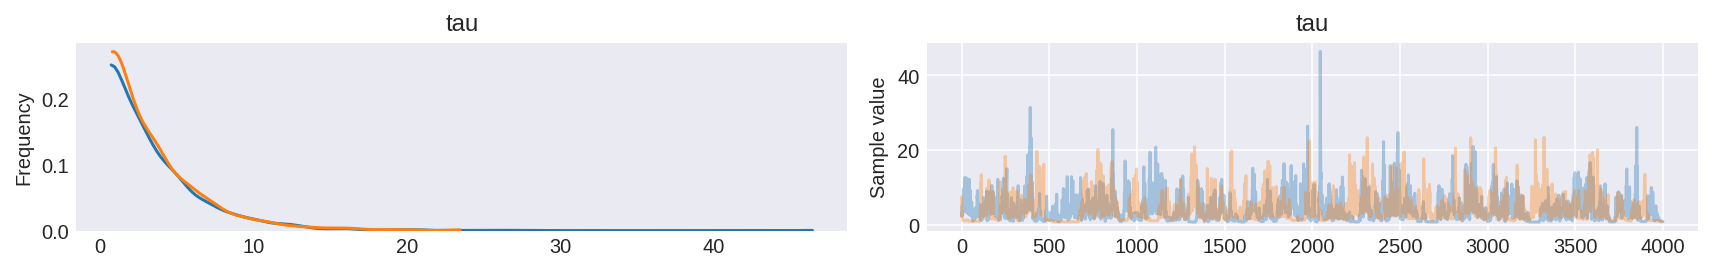

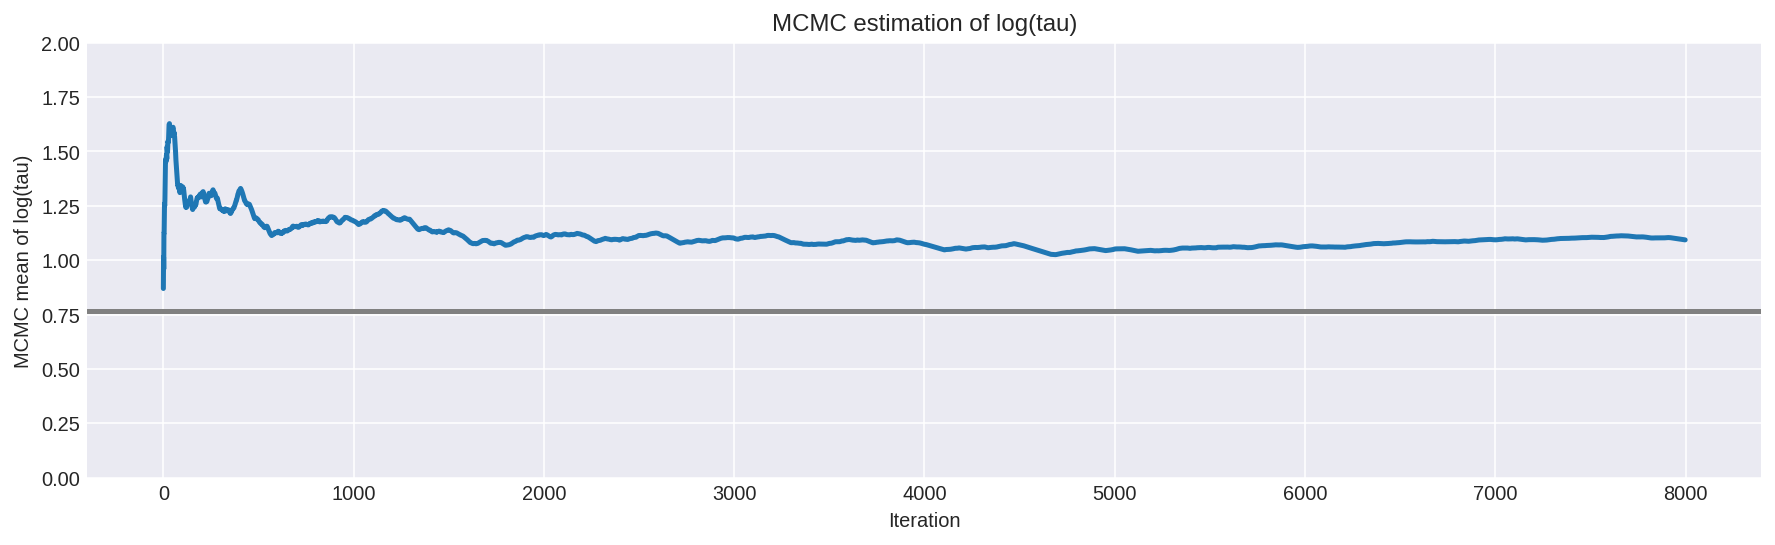

Number of Divergent 321
Percentage of Divergent 0.08025


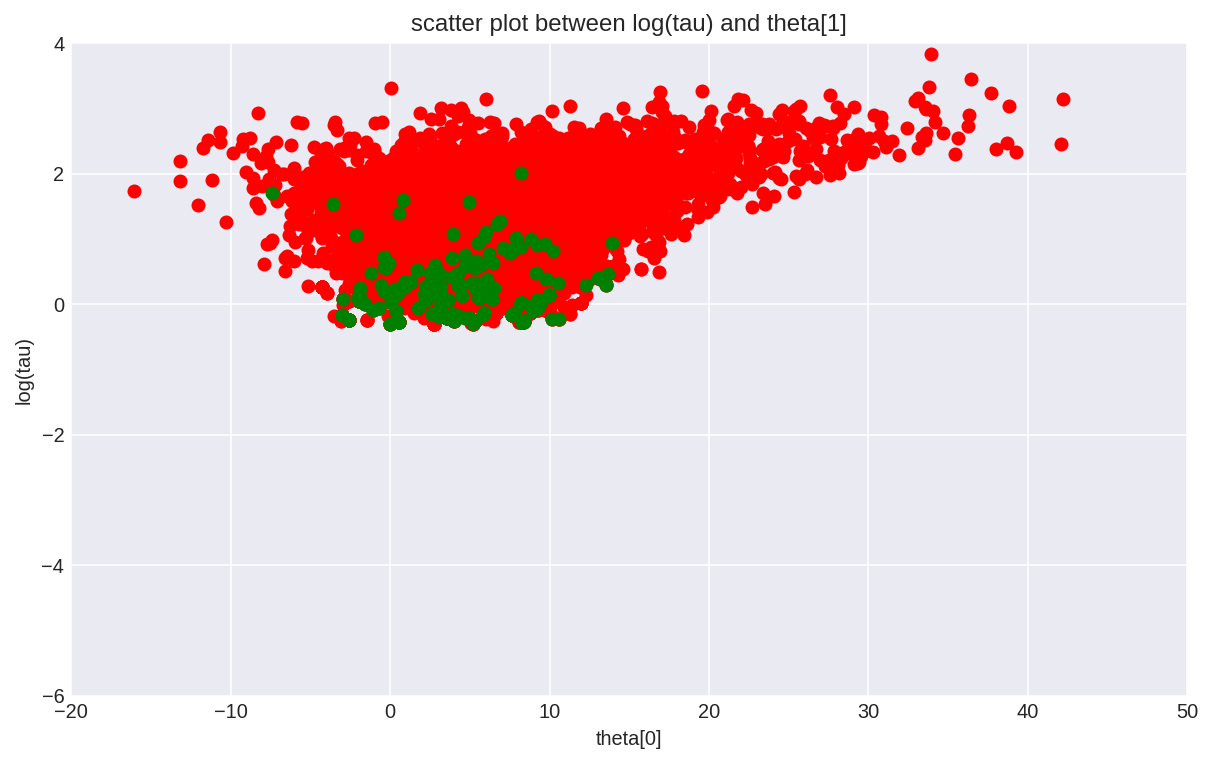

In [39]:
report_trace(longer_trace)


In [40]:
print(pm.diagnostics.gelman_rubin(longer_trace))


{'mu': 1.0049642336229132, 'theta': array([1.00080682, 1.00136814, 1.00407602, 1.00334547, 1.00353724,
       1.00198863, 1.00024518, 1.00076174]), 'tau': 0.9999734295679228}


In [41]:
pm.diagnostics.effective_n(longer_trace)


{'mu': 527.0,
 'tau': 431.0,
 'theta': array([1103., 1079., 1135., 1055.,  853., 1110.,  852., 1414.])}

## Mitigating Divergences by Adjusting PyMC3’s Adaptation Routine
 Divergences in Hamiltonian Monte Carlo arise when the Hamiltonian transition encounters regions of extremely large curvature, such as the opening of the hierarchical  funnel. Unable to accurate resolve these regions, the transition malfunctions and flies off towards infinity. With the transitions unable to completely explore these regions of extreme curvature, we lose geometric ergodicity and our MCMC estimators become biased.

Algorithm implemented in Stan uses a heuristic to quickly identify these misbehaving trajectories, and hence label divergences, without having to wait for them to run all the way to infinity. This heuristic can be a bit aggressive, however, and sometimes label transitions as divergent even when we have not lost geometric ergodicity.

To resolve this potential ambiguity we can adjust the step size, ϵϵ, of the Hamiltonian transition. The smaller the step size the more accurate the trajectory and the less likely it will be mislabeled as a divergence. In other words, if we have geometric ergodicity between the Hamiltonian transition and the target distribution then decreasing the step size will reduce and then ultimately remove the divergences entirely. If we do not have geometric ergodicity, however, then decreasing the step size will not completely remove the divergences.

Like Stan, the step size in PyMC3 is tuned automatically during warm up, but we can coerce smaller step sizes by tweaking the configuration of PyMC3’s adaptation routine. In particular, we can increase the target_accept parameter from its default value of 0.8 closer to its maximum value of 1.

In [42]:
with Centered_eight:
    step = pm.NUTS(target_accept=.85)
    fit_cp85 = pm.sample(5000, step=step, njobs=2, tune=1000, random_seed=SEED)
with Centered_eight:
    step = pm.NUTS(target_accept=.90)
    fit_cp90 = pm.sample(5000, step=step, njobs=2, tune=1000, random_seed=SEED)
with Centered_eight:
    step = pm.NUTS(target_accept=.95)
    fit_cp95 = pm.sample(5000, step=step, njobs=2, tune=1000, random_seed=SEED)
with Centered_eight:
    step = pm.NUTS(target_accept=.99)
    fit_cp99 = pm.sample(5000, step=step, njobs=2, tune=1000, random_seed=SEED)

 98%|█████████▊| 5864/6000 [00:31<00:00, 162.85it/s]/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 92 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 5998/6000 [00:32<00:00, 234.72it/s]/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 92 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 95%|█████████▍| 5676/6000 [00:36<00:02, 144.55it/s]/jupyter_virtual_envs/python2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 38 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 5986/6000 [00:38<00:00, 146.44it/s]/jupyter_

In [43]:
df = pd.DataFrame([longer_trace['step_size'].mean(),
                  fit_cp85['step_size'].mean(),
                  fit_cp90['step_size'].mean(),
                  fit_cp95['step_size'].mean(),
                  fit_cp99['step_size'].mean()], columns=['Step_size'])
df['Divergent'] = pd.Series([longer_trace['diverging'].sum(),
                            fit_cp85['diverging'].sum(),
                            fit_cp90['diverging'].sum(),
                            fit_cp95['diverging'].sum(),
                            fit_cp99['diverging'].sum()])
df['delta'] = pd.Series(['.80', '.85', '.90', '.95', '.99'])
print(df)

   Step_size  Divergent delta
0   0.243758        321   .80
1   0.160561        184   .85
2   0.140450         76   .90
3   0.053268         96   .95
4   0.032899         18   .99


Here, the number of divergent transitions dropped dramatically when delta was increased to 0.99. > This behavior also has a nice geometric intuition. The more we decrease the step size the more the Hamiltonian Markov chain can explore the neck of the funnel. Consequently, the marginal posterior distribution for $log(τ)$ stretches further and further towards negative values with the decreasing step size.

Since in PyMC3 after tuning we have a smaller step size than Stan, the geometery is better explored. > However, the Hamiltonian transition is still not geometrically ergodic with respect to the centered implementation of the Eight Schools model. Indeed, this is expected given the observed bias.

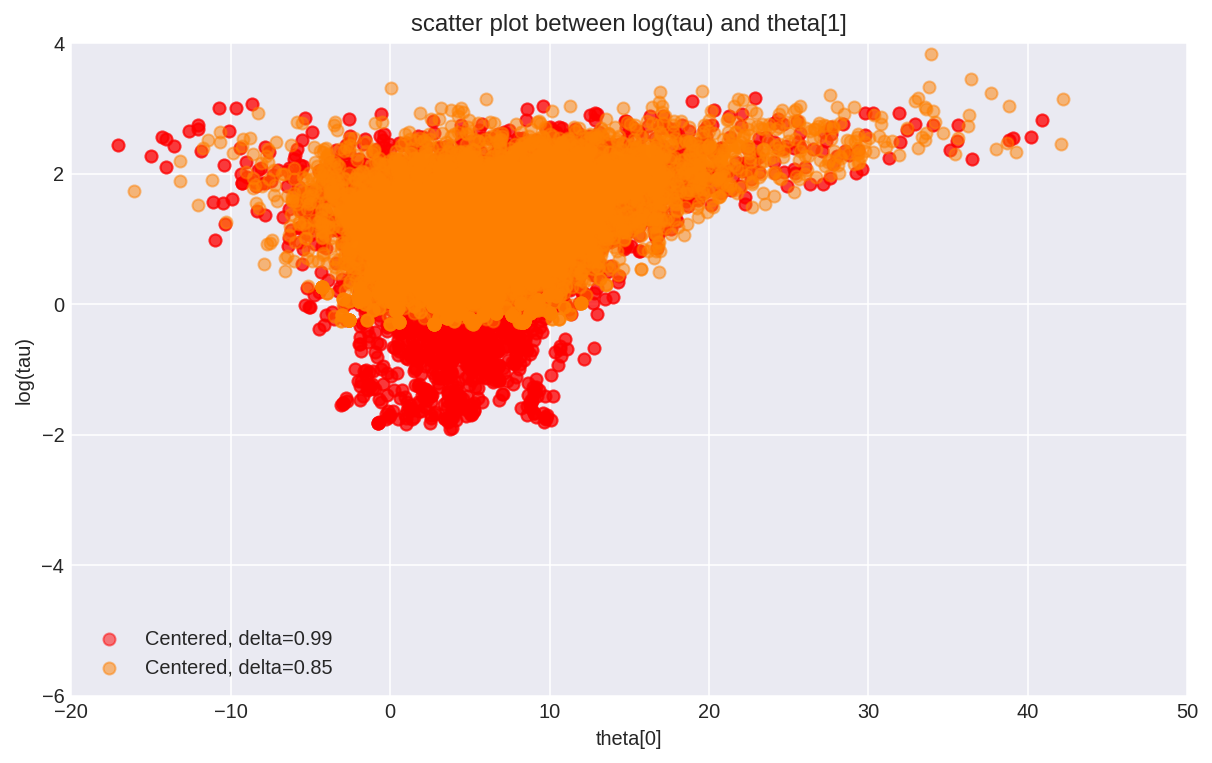

In [44]:
theta0 = longer_trace['theta'][:, 0]
logtau0 = np.log(longer_trace['tau'])
divergent0 = longer_trace['diverging']

theta1 = fit_cp99['theta'][:, 0]
logtau1 = np.log(fit_cp99['tau'])
divergent1 = fit_cp99['diverging']

plt.figure(figsize=(10, 6))
plt.scatter(theta1[divergent1 == 0], logtau1[divergent1 == 0],
            color='r', alpha=.5, label='Centered, delta=0.99')
plt.scatter(theta0[divergent0 == 0], logtau0[divergent0 == 0],
            color=[1, .5, 0], alpha=.5, label='Centered, delta=0.85')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[1]')
plt.legend()

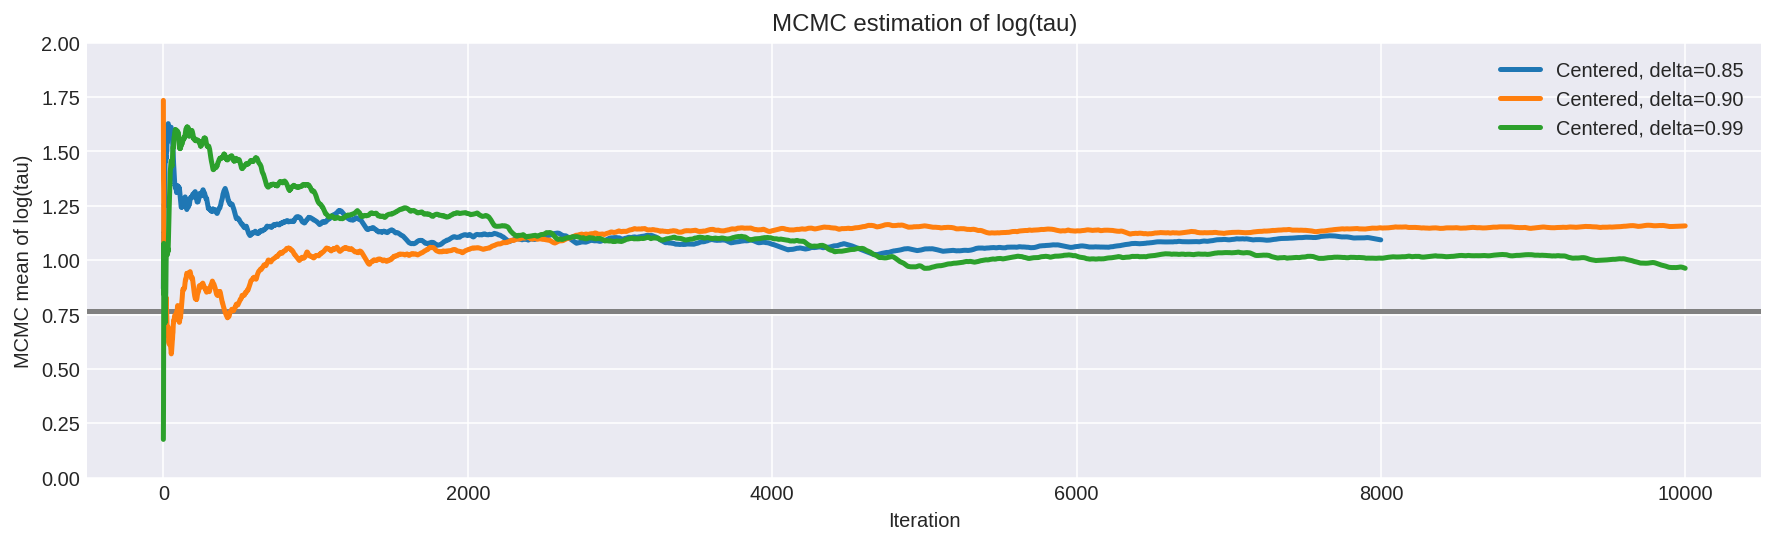

In [45]:

logtau2 = np.log(fit_cp90['tau'])

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, label='Centered, delta=0.85', lw=2.5)
mlogtau2 = [np.mean(logtau2[:i]) for i in np.arange(1, len(logtau2))]
plt.plot(mlogtau2, label='Centered, delta=0.90', lw=2.5)
mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, label='Centered, delta=0.99', lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend()

## A successful fit
Multiple diagnostics have indicated that our fit of the centered parameterization of our hierarchical model is not to be trusted, so let’s instead consider the complementary non-centered parameterization

Although reducing the step size improves exploration, ultimately it only reveals the true extent the pathology in the centered implementation. Fortunately, there is another way to implement hierarchical models that does not suffer from the same pathologies.

In a non-centered parameterization we do not try to fit the group-level parameters directly, rather we fit a latent Gaussian variable from which we can recover the group-level parameters with a scaling and a translation.

$μ∼N(0,5)$

$τ∼ Half Cauchy(0,5)$

$\tilde{θ}_n∼N(0,1)$

$θ_n=μ+τ⋅\tilde{θ}_{n}.$

In [46]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [47]:
with NonCentered_eight:
    step = pm.NUTS(target_accept=.80)
    fit_ncp80 = pm.sample(5000, step=step, njobs=2, tune=1000, random_seed=SEED)

100%|██████████| 6000/6000 [00:14<00:00, 423.08it/s]


In [48]:
print(pm.diagnostics.gelman_rubin(fit_ncp80))


{'mu': 0.9998999949995, 'tau': 0.9998999949994999, 'theta_t': array([0.99989999, 0.99989999, 0.99989999, 0.99989999, 0.99989999,
       0.99989999, 0.99989999, 0.99989999]), 'theta': array([0.99989999, 0.99989999, 0.99989999, 0.99989999, 0.99989999,
       0.99989999, 0.99989999, 0.99989999])}


In [49]:
print(pm.diagnostics.effective_n(fit_ncp80))


{'mu': 10000.0, 'tau': 7000.0, 'theta_t': array([10000., 10000., 10000., 10000., 10000., 10000., 10000., 10000.]), 'theta': array([ 8977., 10000., 10000., 10000., 10000., 10000., 10000., 10000.])}


As shown above, the effective sample size per iteration has drastically improved, and the trace plots no longer show any “stickyness”. However, we do still see the rare divergence. 

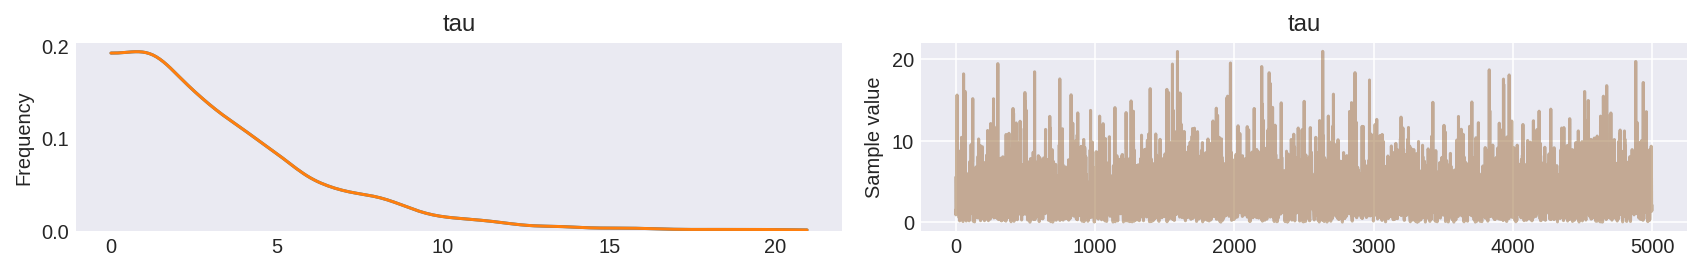

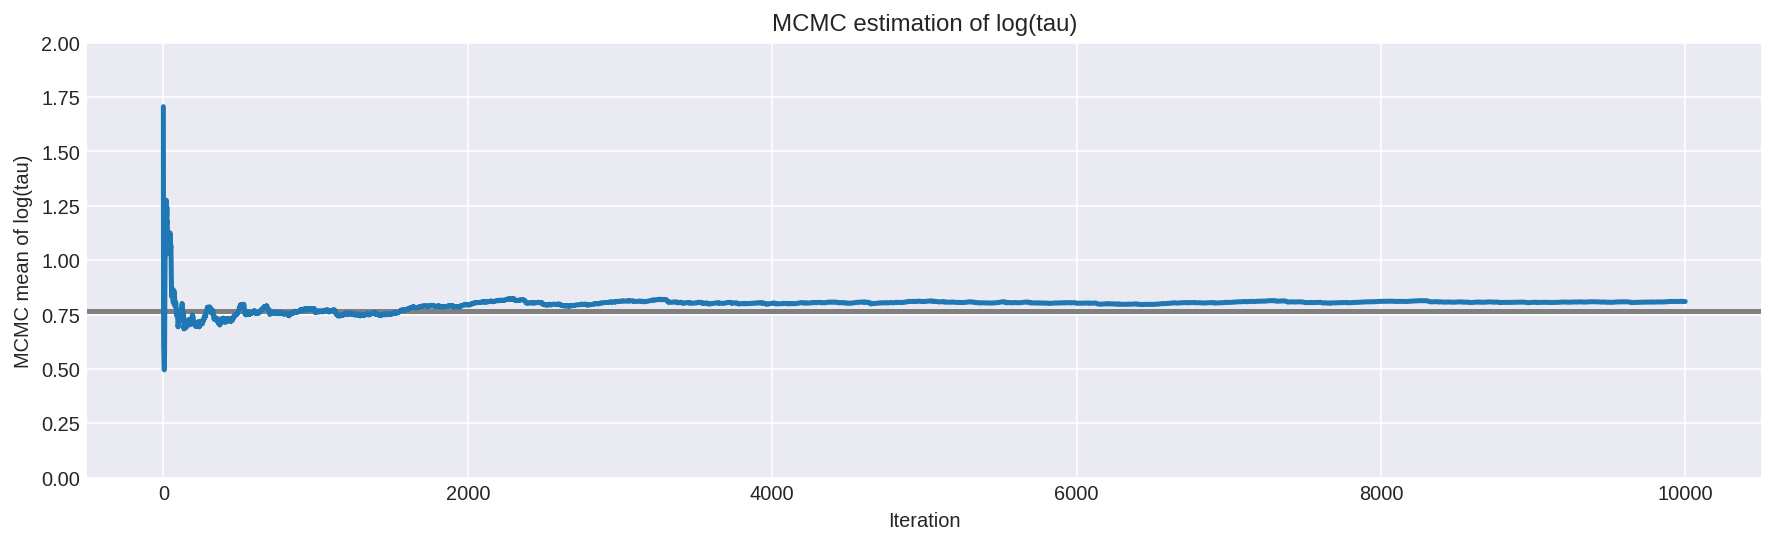

Number of Divergent 0
Percentage of Divergent 0.00000


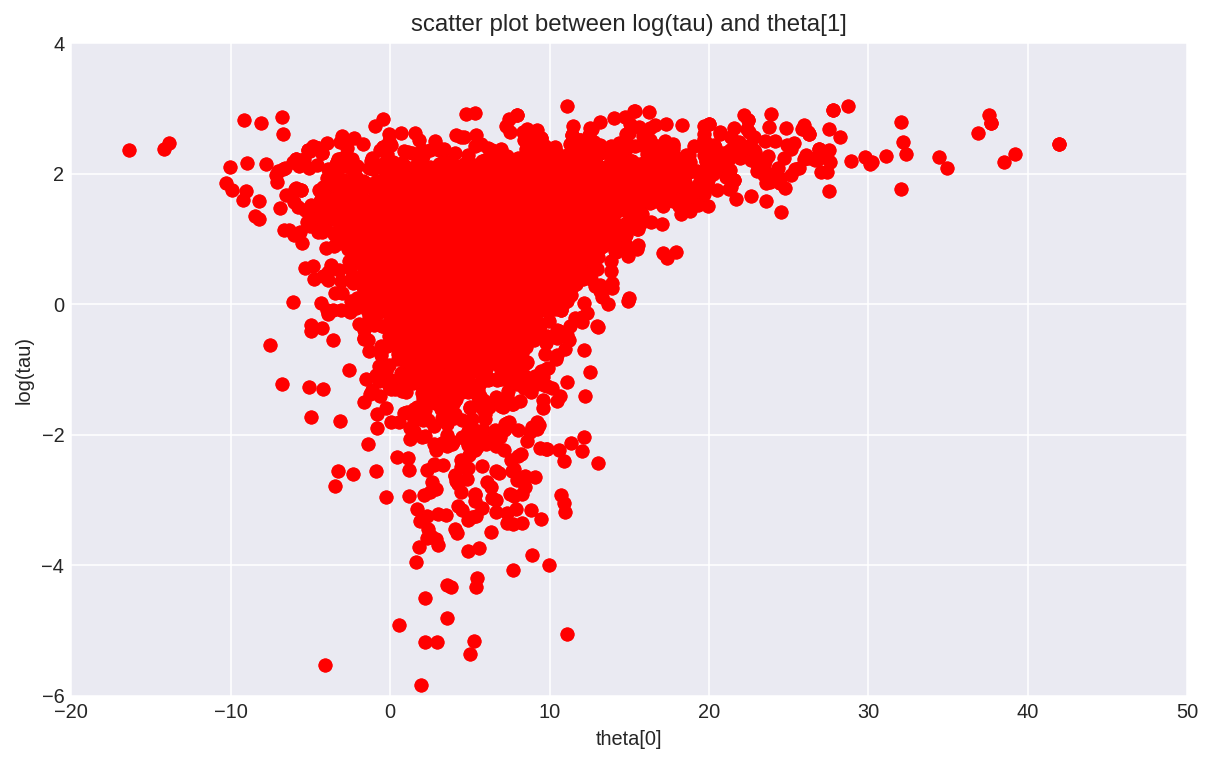

In [50]:
report_trace(fit_ncp80)


The more agreeable geometry of the non-centered implementation allows the Markov chain to explore deep into the neck of the funnel, capturing even the smallest values of $τ$ that are consistent with the measurements. Consequently, MCMC estimators from the non-centered chain rapidly converge towards their true expectation values.

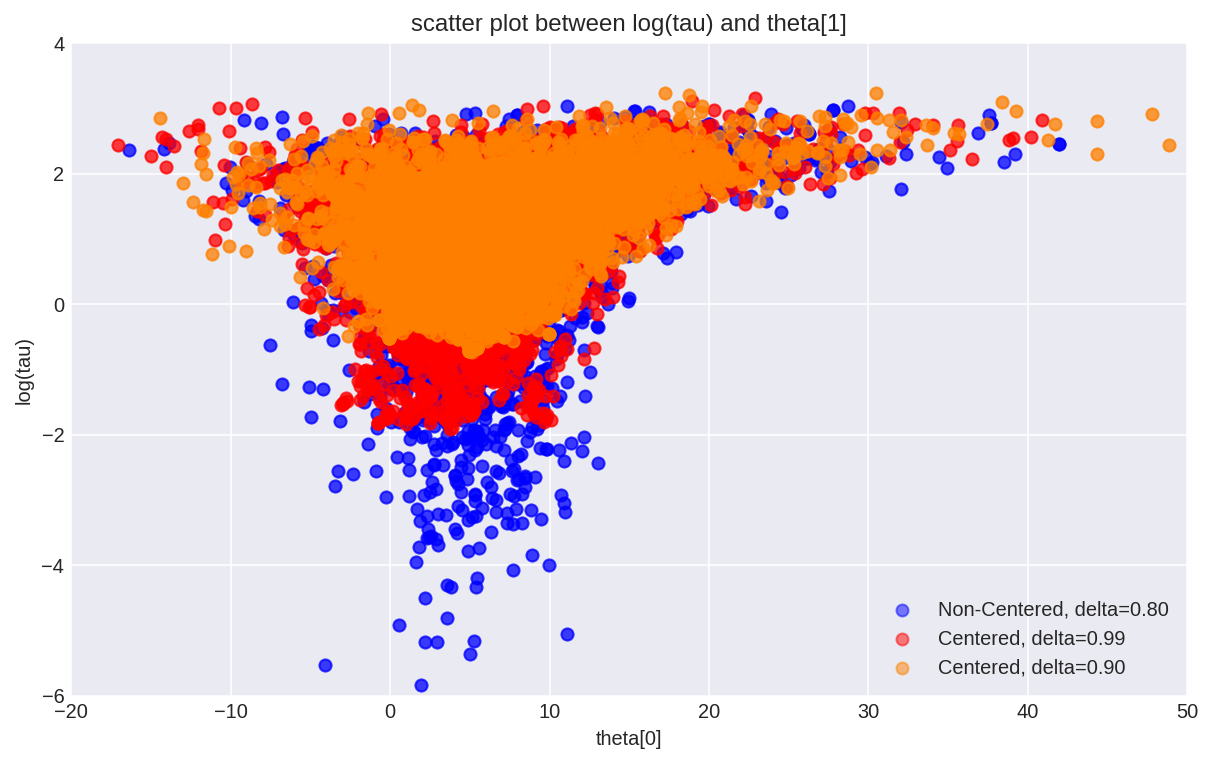

In [51]:
theta0 = fit_cp90['theta'][:, 0]
logtau0 = np.log(fit_cp90['tau'])
divergent0 = fit_cp90['diverging']

theta1 = fit_cp99['theta'][:, 0]
logtau1 = np.log(fit_cp99['tau'])
divergent1 = fit_cp99['diverging']

thetan = fit_ncp80['theta'][:, 0]
logtaun = np.log(fit_ncp80['tau'])
divergentn = fit_ncp80['diverging']

plt.figure(figsize=(10, 6))
plt.scatter(thetan[divergentn == 0], logtaun[divergentn == 0],
            color='b', alpha=.5, label='Non-Centered, delta=0.80')
plt.scatter(theta1[divergent1 == 0], logtau1[divergent1 == 0],
            color='r', alpha=.5, label='Centered, delta=0.99')
plt.scatter(theta0[divergent0 == 0], logtau0[divergent0 == 0],
            color=[1, 0.5, 0], alpha=.5, label='Centered, delta=0.90')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[1]')
plt.legend()

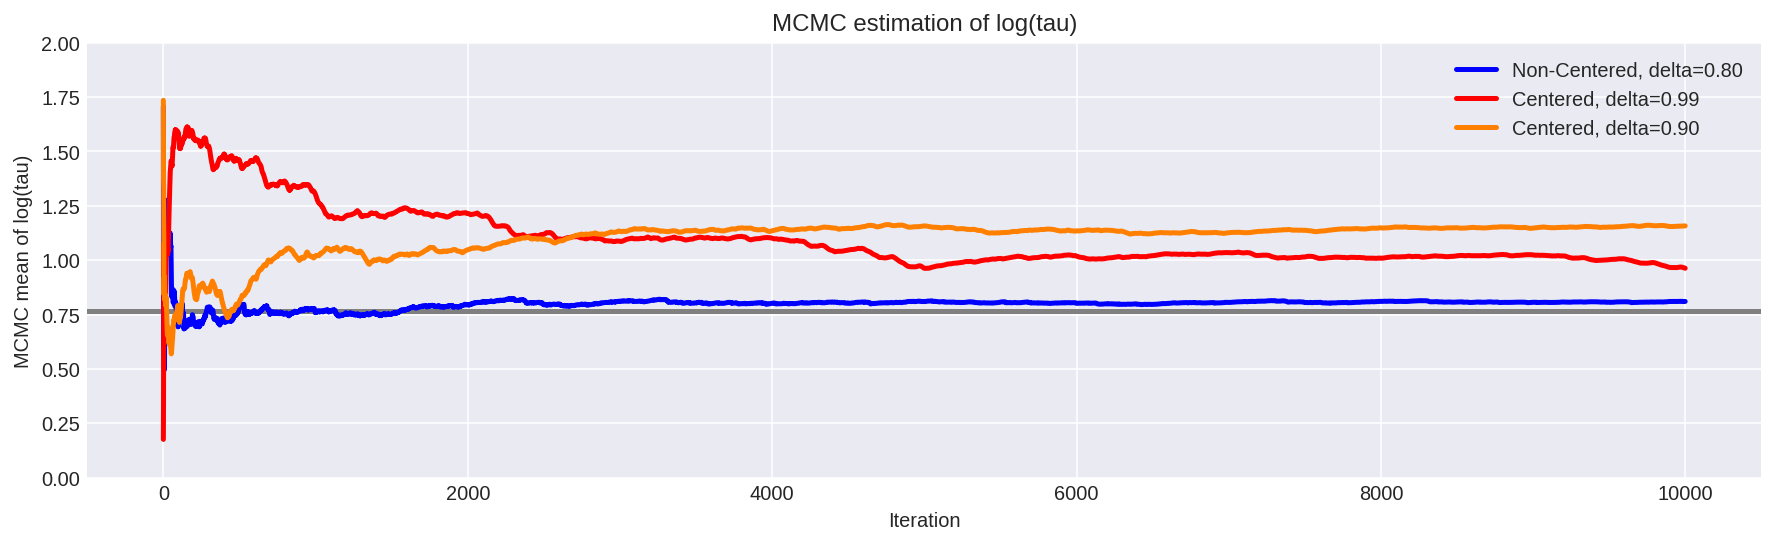

In [52]:
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
mlogtaun = [np.mean(logtaun[:i]) for i in np.arange(1, len(logtaun))]
plt.plot(mlogtaun, color='b', lw=2.5, label='Non-Centered, delta=0.80')

mlogtau1 = [np.mean(logtau1[:i]) for i in np.arange(1, len(logtau1))]
plt.plot(mlogtau1, color='r', lw=2.5, label='Centered, delta=0.99')

mlogtau0 = [np.mean(logtau0[:i]) for i in np.arange(1, len(logtau0))]
plt.plot(mlogtau0, color=[1, 0.5, 0], lw=2.5, label='Centered, delta=0.90')
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')
plt.legend()

## Results
Let's look at some results, let's look at the effect we're trying to model and that's $\theta_{j}$

We'll see that the general conclusion from the figures below is that an effect as large as 28.4 points in any school is unlikely. For example our HPD - (our credibility interval) doesn't touch 28.(See below). 

School A ends up with an estimated true effect of 6 points, with about 50% of the probability between 3 and 9 points.
(We see some variance between this model and models in Stan, and this is probably due to differences in the random number generators, or in the NUTS sampler. - So don't be alarmed if you see different results in different models.) 

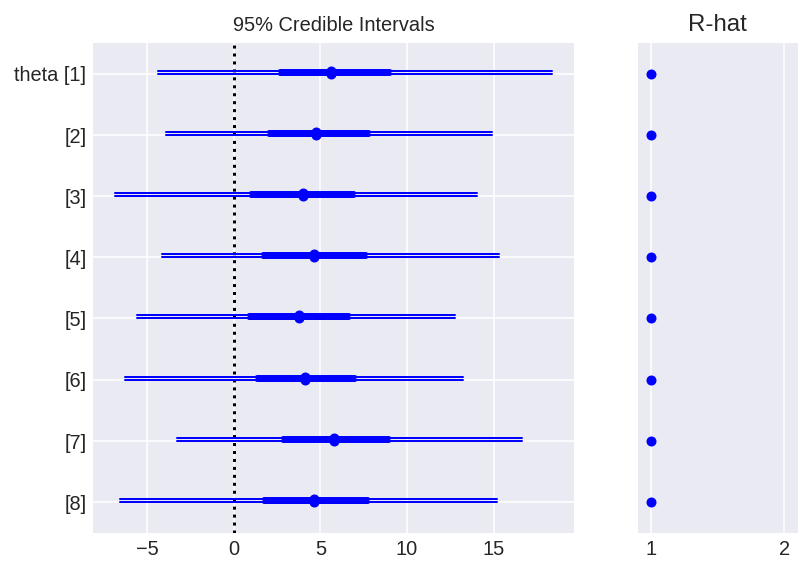

In [53]:
pm.forestplot(fit_ncp80, varnames=['theta']);


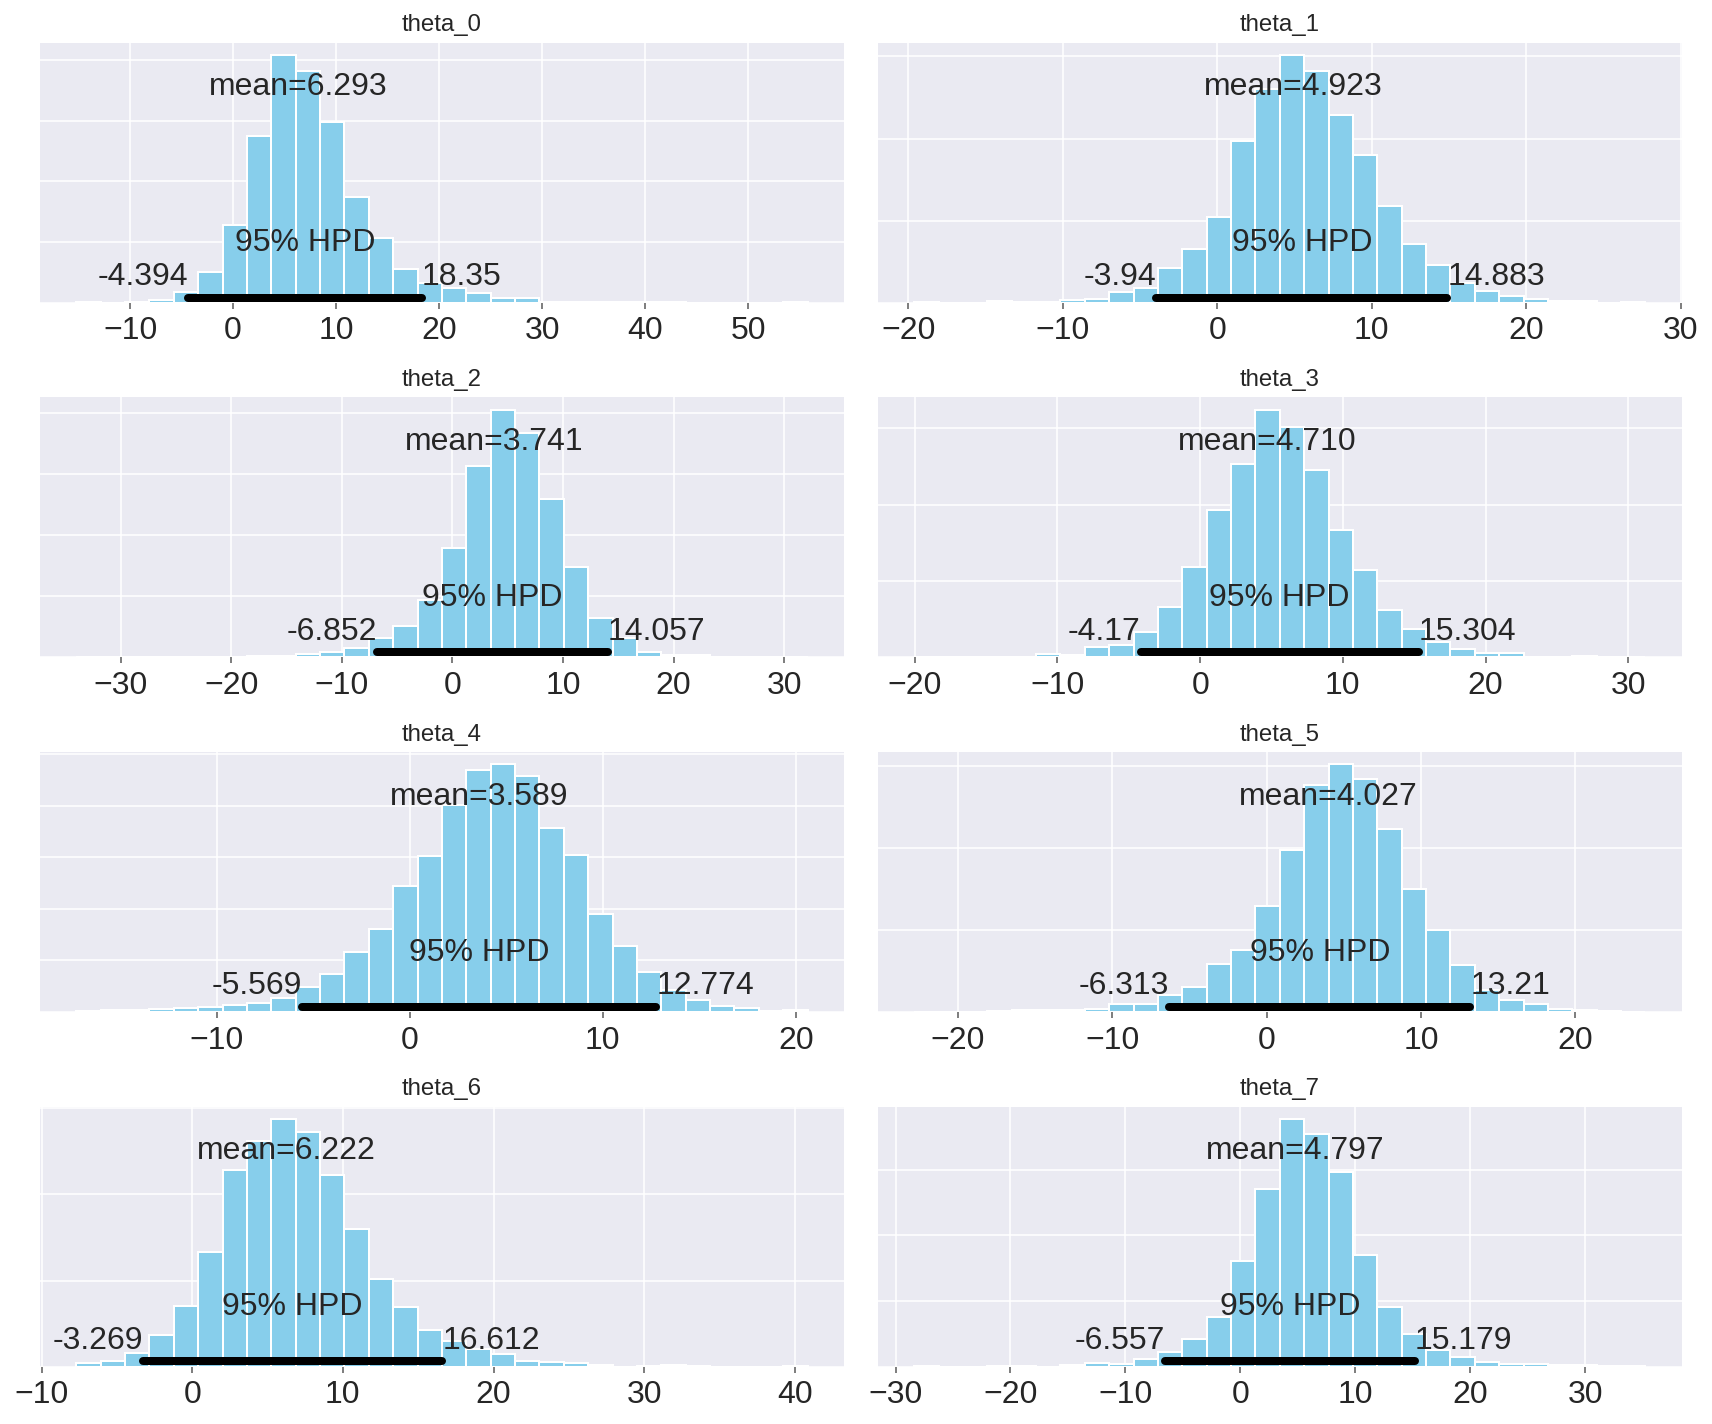

In [54]:
pm.plot_posterior(fit_ncp80, varnames=['theta'], 
                  color='#87ceeb');

In [55]:
pm.stats.summary(fit_ncp80, varnames=['theta'])


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  6.293            5.847            0.061            [-4.394, 18.350]
  4.923            4.748            0.038            [-3.940, 14.883]
  3.741            5.218            0.048            [-6.852, 14.057]
  4.710            4.872            0.038            [-4.170, 15.304]
  3.589            4.658            0.040            [-5.569, 12.774]
  4.027            4.838            0.056            [-6.313, 13.210]
  6.222            5.030            0.047            [-3.269, 16.612]
  4.797            5.388            0.049            [-6.557, 15.179]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -3.175         2.658          5.602          8.988          20.500
  -4.386         2.006          4.732          7.814         

To sum up, the Bayesian analysis of this example not only allows straightforward inferences about many parameters that may be of interest, but the hierarchical model is flexible enough to adapt to the data, thereby providing posterior inferences that account for the partial pooling as well as the uncertainty in the hyperparameters.

## References/ Resources

* Betancourt, Michael. 2017. “A Conceptual Introduction to Hamiltonian Monte Carlo.” ArXiv E-Prints 1701.02434 (January). https://arxiv.org/abs/1701.02434 

* Rubin, Donald B. 1981. “Estimation in Parallel Randomized Experiments.” Journal of Educational and Behavioral Statistics 6 (4): 377–401.

* https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers - by Cameron Davidson-Pilon. Scroll down to the PyMC3 part in the README.


We don't use R or Stan, but the principles remain the same. 

* http://xcelab.net/rm/statistical-rethinking/ : A Bayesian Course with Examples in R and Stan by Richard McElreath.

* http://www.stat.columbia.edu/~gelman/book/ , by Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin. 3rd Edition., 
* http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf - Shalizi’s Advanced Data Analysis from an Elementary Point of View
* http://www.stat.cmu.edu/~larry/all-of-statistics/ - Wasserman’s All of Statistics